# Simulate acoustic wave propagation of a planar piston source

The OptimUS library provides functionality to simulate acoustic wave propagation from a range of acoustic sources. This notebook demonstrates a simulation with a circular planar piston rigidly vibrating in an infinite baffle. Acoustic intensity and power calculations are carried out. Output quantities are compared with known analytical solutions. The piston velocity is scaled to produce the required acoustic power and the model is solved in the presence of a spherical scatterer.

## Import the OptimUS library

Load the OptimUS library.

In [1]:
# Make sure the OptimUS library is in the Python path.
import sys
sys.path.append('..')

In [2]:
import optimus

## Specify a circular planar piston as acoustic source

The OptimUS library provides different predefined wave fields, among which is a circular planar piston source radiating in 2*pi space. The piston requires the frequency, outer radius and radius of curvature to be specified and, optionally, the source axis, the velocity and its location, which is in this case at [0, 0, 0].

In [3]:
frequency = 1e6
piston_radius = 0.01
location = (0, 0, 0)
velocity = 1.0
source = optimus.source.create_piston(frequency, radius=piston_radius, location=location, source_axis=(1, 0, 0),
                                    velocity=velocity, number_of_point_sources_per_wavelength=12)

## Specify the physical settings for the simulation

Let us consider a fat sphere embedded in an unbounded region of non-attenuating water.

In [4]:
sphere_radius = 7.5e-3
geometry = optimus.geometry.shapes.Sphere(radius=7.5e-3, element_size=0.5e-3, origin=(0.04, 0, 0))

material_ext = optimus.material.create_material(name='water-no-attenuation',
                                                   density=1000,
                                                   speed_of_sound=1500)
material_int = optimus.material.load_material('bone (cortical)')

## Print material properties

In [5]:
material_ext.print()
material_int.print()

                 name  density  speed_of_sound  attenuation_coeff_a  attenuation_pow_b
 water-no-attenuation   1000.0          1500.0                  0.0                0.0
            name  density  speed_of_sound  attenuation_coeff_a  attenuation_pow_b
 bone (cortical)   1908.0     3514.857143               54.553                1.0


## Simulate the wave model

The OptimUS library uses the Boundary Element Method to simulate acoustic wave propagation. Let us use a model with default settings.

In [6]:
model = optimus.model.create_default_model(source, geometry, material_ext, material_int)

## Rename exterior medium properties

In [7]:
import numpy as np
rho = material_ext.density
c = material_ext.speed_of_sound
f = source.frequency
k = np.abs(material_ext.compute_wavenumber(f))
lambd = np.real(2 * np.pi / k)

## Obtain coordinates of points in a line parallel to the $z$ axis passing through $x$ = 10 mm

This is for obtaining the acoustic power.

In [8]:
x_offset = 10.0e-3
y_offset = 0.0
zmin = 0.0
zmax = 15 * piston_radius
nz = int(zmax / lambd * 24)
x_field = x_offset * np.ones(nz)
y_field = y_offset * np.ones(nz)
z_field = np.linspace(zmin, zmax, nz)
points = np.array((np.row_stack((x_field, y_field, z_field))))

## Generate unit normals at points on integration line

In [9]:
normals = np.zeros((3, points.shape[1]), dtype=float)
normals[0, :] = np.ones(points.shape[1], dtype=float)

## Calculate the incident field on a disc whose radius is 15 times the piston radius

Retrieve the incident pressure and calculate the particle velocity in along the $x$ direction. Calculate the $x$ component of the acoustic intensity.

In [10]:
from optimus.source.transducers import transducer_field
inc_field = transducer_field(source, material_ext, points, normals=normals, verbose=True)
p_inc = inc_field.pressure
u_inc = inc_field.normal_pressure_gradient / (1j * 2 * np.pi * f * rho)
Ix = np.real(0.25 * (p_inc * np.conj(u_inc) + np.conj(p_inc) * u_inc))

Number of point sources across element diameter: 160
Number of point sources in transducer: 19856
Parallelisation method: multiprocessing
Parallelisation of incident field calculation over source locations


## Plot the acoustic intensity along the radius of the disc over which the field is to be integrated

Text(0, 0.5, 'Acoustic intensity (W/$m^{-2}$)')

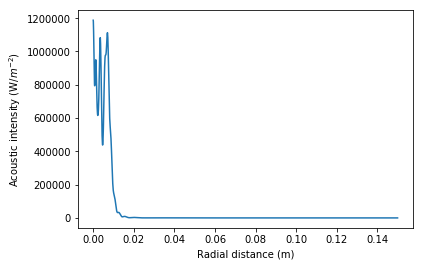

In [11]:
from matplotlib import pylab as plt
%matplotlib inline
plt.plot(points[2], Ix)
plt.xlabel('Radial distance (m)')
plt.ylabel('Acoustic intensity (W/$m^{-2}$)')

## Calculate acoustic power per unit velocity

Say we require an acoustic power of 0.3 W. Let us calculate the piston velocity to produce this output power.

In [12]:
power_at_unit_velocity = 2 * np.pi * np.sum(Ix * points[2]) * points[2, 1]
# Required acoustic power
power = 0.3
# Calculate velocity to produce required power
piston_velocity = np.sqrt(power / power_at_unit_velocity)
print('The required piston velocity to generate ', power ,'W of acoustic power is ',power_at_unit_velocity, 'm/s')

The required piston velocity to generate  0.3 W of acoustic power is  234.5245746565573 m/s


## Check that the calculated piston velocity is in agreement with the analytical solution

http://www.silcom.com/~aludwig/Physics/Exact_piston/Exact_piston.htm

In [13]:
import scipy as sp
piston_velocity_check = np.sqrt( 2 * power / (np.pi * piston_radius ** 2 * rho * c
                                * (1 - 2 * sp.special.jv(1, 2 * k * piston_radius) / (2 * k * piston_radius))))
print('Estimated velocity to produce ', power, ' W of acoustic power: ', piston_velocity_check, 'm/s')
print('Analytical value of velocity which produces ', power, ' W of acoustic power: ', piston_velocity, 'm/s')
print('Percentage difference with analytical solution: ', 100 * np.linalg.norm((piston_velocity_check
                                                                                - piston_velocity) / piston_velocity), '%')

Estimated velocity to produce  0.3  W of acoustic power:  0.03571844441568981 m/s
Analytical value of velocity which produces  0.3  W of acoustic power:  0.035765676897392636 m/s
Percentage difference with analytical solution:  0.1320609192951357 %


## Check that the power is in agreement with the analytical solution

In [14]:
bessel_func_term = sp.special.jv(1, 2 * k * piston_radius) / (2 * k * piston_radius)
power_check = 0.5 * piston_velocity ** 2 * np.pi * piston_radius ** 2 * rho * c * (1 - 2 * bessel_func_term)
print('Required acoustic power: ', power, ' W')
print('Analytical value of power produced by estimated velocity:', power_check, ' W')
print('Percentage difference with analytical solution: ', 100 * np.linalg.norm((power_check - power) / power), '%')

Required acoustic power:  0.3  W
Analytical value of power produced by estimated velocity: 0.30079393789190145  W
Percentage difference with analytical solution:  0.2646459639671547 %


## Assign velocity to piston source to produce required power and update model

In [15]:
source.velocity = piston_velocity
model = optimus.model.create_default_model(source, geometry, material_ext, material_int)

## Solve model

In [16]:
model.solve()

Parallelisation method: multiprocessing
Parallelisation of incident field calculation over source locations


## Visualisation of the acoustic field

Let us visualise the total pressure field on a grid in the plane $z$=0.

In [17]:
postprocess_plane = optimus.postprocess.VisualisePlane(model)
postprocess_plane.create_computational_grid(resolution=(101, 51), bounding_box=(0.005, 0.08, -2 * piston_radius,
                                            2 * piston_radius), plane_axes=(0, 1))
postprocess_plane.compute_fields()

Parallelisation method: multiprocessing
Parallelisation of incident field calculation over source locations


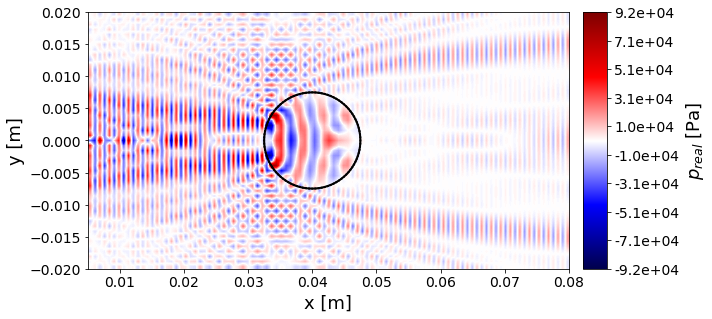

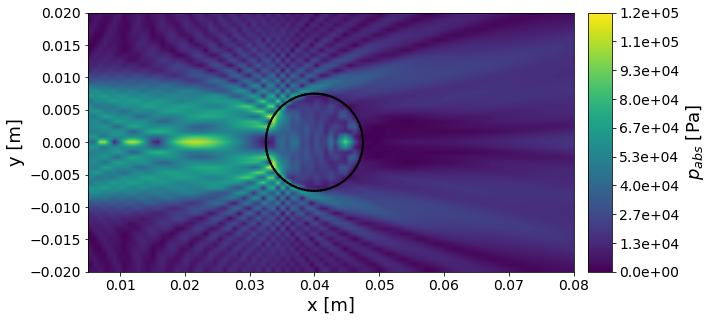

In [18]:
%matplotlib inline
figs = optimus.postprocess.plot_pressure_field(postprocess_plane, field="total")